<a href="https://colab.research.google.com/github/hughes28/CSGOKnifeDataAnalysis/blob/master/CSGOKnifeDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS:GO Knives Dataset Analysis**

## **Background on Dataset**

### What exactly are these knives?

#### These knives are cosmetic items players can get in the game Counter Strike: Global Offensive (CS:GO) by unboxing crates which are won when players win matches (and open them with keys for a price). They are purely cosmetic in nature and offer no in-game benefit, yet some have unique designs and are mostly used as items to show off to other players. Some knives go for over $1000. 

### How is this data extracted?

#### The dataset is extracted through a Python web scraper; the web scraper goes to the Steam Marketplace (where these knives are sold) and extracts information about each knife, including:

1.   Knife Type (i.e. Karambit, Bayonet)
2.   Knife Skin (i.e. Tiger Tooth, Case Hardened)
3.   Knife Skin Quality (i.e. Battle-Scarred, Factory New)
4.   StatTrak (the ability for the knife to track kills)
5.   Price (USD) (technically, the *minimum* price to buy the knife on the Marketplace)
6.   Quantity (the number of knives of a given type on the Marketplace)

The dataset is not complete, however, as some skins are only available on certain knives and some players just aren't selling certain types of knives on the Marketplace at the time the dataset was compiled.



### How do I get this set up?

#### Run the file (Runtime -> Restart and run all) and, under "Getting Set Up", click "Choose Files" and upload the database. It should be in .db format as output from the web scraper file. Once that is uploaded, check the plots below! If you are interested in how data was manipulated/accessed, check the hidden cells for the Python code written.

## **Getting Set Up**

#### Import necessary Python libraries/database

In [1]:
import sqlite3 
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Select the database generated by the CS:GO Webscraper

In [2]:
database = files.upload()

Saving knives_sample.db to knives_sample.db


#### Format database and generate statistics

##### Change extension from .db to .sqlite (Google Collab sqlite3 reads .sqlite)

In [3]:
file_name = list(database.keys())[0][0:-3] # Extracts pure name of file
new_file_name = file_name + '.sqlite'
os.rename('/content/' + file_name + '.db', '/content/' + new_file_name)
print(f'Successfully uploaded {new_file_name}')

Successfully uploaded knives_sample.sqlite


##### Connect to database and create cursor object. Generate basic statistics.

In [0]:
conn = sqlite3.connect('/content/' + new_file_name)
c = conn.cursor()

# Find quantity of knives on entire Steam Marketplace
c.execute(f"SELECT sum(quantity) FROM knives") 
total_knives = c.fetchall()[0][0]

# Find total number of distinct knives
c.execute(f"SELECT COUNT(*) FROM knives")
size = c.fetchall()[0][0]

# Find total number of knife types
c.execute(f'SELECT COUNT(DISTINCT(knife_type)) FROM knives') 
knife_types = c.fetchall()[0][0]

# Find total number of knife skins
c.execute(f'SELECT COUNT(DISTINCT(knife_skin)) FROM knives') 
knife_skins = c.fetchall()[0][0]

# Find total number of knife skin qualities and amounts
c.execute(f'SELECT COUNT(DISTINCT(knife_skin_quality)) FROM knives') 
knife_skin_qualities = c.fetchall()[0][0]

# Find percent of knives that are StatTrak out of whole database
c.execute(f"SELECT COUNT(stattrak) FROM knives WHERE stattrak='1'") 
stattrak = c.fetchall()[0][0]

def print_statistics():
  print('Database Statistics:')
  print('')
  print(f'{total_knives} knives are on the Steam Marketplace.')
  print(f'{size} distinct knives currently in this database.')
  print(f'{knife_types} knife types currently in this database.')
  print(f'{knife_skins} knife skins currently in this database.')
  print(f'{knife_skin_qualities} knife skin qualities currently in this database.')
  print("     - including 'N/A'")
  print(f'{round(stattrak/size, 3)*100}% of all knives are StatTrak.')

## **Database Quick Statistics**

In [5]:
print_statistics()

Database Statistics:

10868 knives are on the Steam Marketplace.
2133 distinct knives currently in this database.
19 knife types currently in this database.
26 knife skins currently in this database.
6 knife skin qualities currently in this database.
     - including 'N/A'
40.8% of all knives are StatTrak.


## **Data Plots**

### Plot 1: Heatmap of Knives' Prices Based on Skin and Skin Quality

#### Prepare data/graph

##### Execute SQL query to obtain knife skin, knife skin quality, and average price grouped by each skin

In [6]:
c.execute("SELECT knife_skin, knife_skin_quality, avg(price_usd) "
          f"FROM knives "
          "WHERE knife_skin_quality != 'N/A' "
          "GROUP BY knife_skin, knife_skin_quality")

##### Convert cursor to useable data as a DataFrame object


In [0]:
data1 = c.fetchall()
df1 = pd.DataFrame(data1, columns=['Knife Skin',
                                 'Knife Skin Quality',
                                 'Average Price (USD)'])

##### Convert DataFrame object into pivot table to plot data as a heatmap

In [0]:
pivot1 = df1.pivot_table(values=['Average Price (USD)'],
                       index=['Knife Skin Quality'],
                       columns='Knife Skin',
                       fill_value=0) # White spaces on the heatmap are "null"

##### Generate manual x values (allows word formatting to be easier in graph).

In [9]:
x_values_1 = []

# Gets all unique Knife Skins while keeping format
[x_values_1.append(x) for x in df1['Knife Skin'] if x not in x_values_1]

x_values_1 = sorted(x_values_1)
print(x_values_1)

['Autotronic', 'Black Laminate', 'Blue Steel', 'Boreal Forest', 'Bright Water', 'Case Hardened', 'Crimson Web', 'Damascus Steel', 'Doppler', 'Fade', 'Forest DDPAT', 'Freehand', 'Gamma Doppler', 'Lore', 'Marble Fade', 'Night', 'Night Stripe', 'Rust Coat', 'Safari Mesh', 'Scorched', 'Slaughter', 'Stained', 'Tiger Tooth', 'Ultraviolet', 'Urban Masked']


##### Set up heat map and plot data

In [0]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
def show_plot1():
  sns.heatmap(pivot1, cmap='RdPu', xticklabels=x_values_1, square=True)
  fig1 = plt
  fig1.title('Price (USD) Given Skin & Quality of CS:GO Knives')
  fig1.xlabel('Knife Skin')
  fig1.ylabel('Knife Skin Quality')
  fig1.show()

#### Show graph

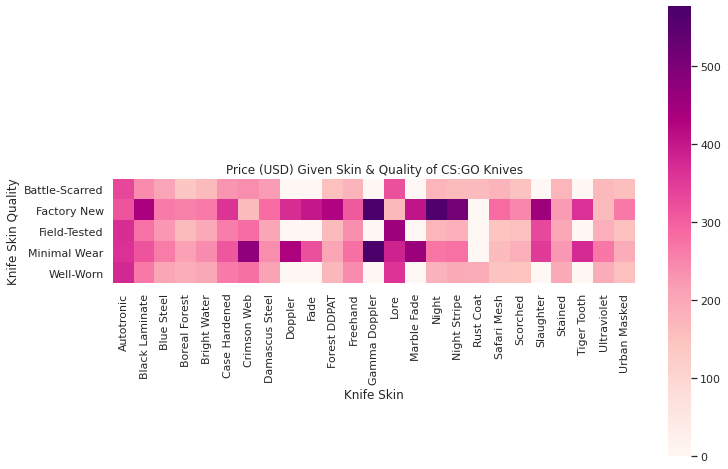

In [11]:
show_plot1()

##### Based on this data, Minimal Wear and Factory New knives are the most expensive out of skin qualities. In addition, skins like Autotronic, Doppler, Fade, Gamma Doppler, Lore, Marble Fade, Night, Slaughter, and Tiger Tooth seem to be the most expensive skins.

### Plot 2: Heatmap of Knives' Prices Based on Knife Type and Skin

#### Prepare data/graph

##### Execute SQL query to obtain knife type, knife skin, and average price grouped by each skin

In [12]:
c.execute("SELECT knife_type, knife_skin, avg(price_usd) "
          "FROM knives "
          "WHERE knife_skin != 'N/A' "
          "GROUP BY knife_type, knife_skin")

##### Convert cursor to useable data as a DataFrame object


In [0]:
data2 = c.fetchall()
df2 = pd.DataFrame(data2, columns=['Knife Type',
                                 'Knife Skin',
                                 'Average Price (USD)'])

##### Convert DataFrame object into pivot table to plot data as a heatmap

In [0]:
pivot2 = df2.pivot_table(values=['Average Price (USD)'],
                       index=['Knife Type'],
                       columns='Knife Skin',
                       fill_value=0) # White spaces on the heatmap are "null"

##### Generate manual x values (allows word formatting to be easier in graph)

In [15]:
x_values_2 = []

# Gets all unique Knife Skins while keeping format
[x_values_2.append(x) for x in df2['Knife Skin'] if x not in x_values_2]

x_values_2 = sorted(x_values_2)
print(x_values_2)

['Autotronic', 'Black Laminate', 'Blue Steel', 'Boreal Forest', 'Bright Water', 'Case Hardened', 'Crimson Web', 'Damascus Steel', 'Doppler', 'Fade', 'Forest DDPAT', 'Freehand', 'Gamma Doppler', 'Lore', 'Marble Fade', 'Night', 'Night Stripe', 'Rust Coat', 'Safari Mesh', 'Scorched', 'Slaughter', 'Stained', 'Tiger Tooth', 'Ultraviolet', 'Urban Masked']


##### Set up heat map and plot data

In [0]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
def show_plot2():
  sns.heatmap(pivot2, cmap='RdPu', xticklabels=x_values_2, square=True)
  fig2 = plt
  fig2.title('Price (USD) Given Type & Skin of CS:GO Knives')
  fig2.xlabel('Knife Skin')
  fig2.ylabel('Knife Type')
  fig2.show()

#### Show graph

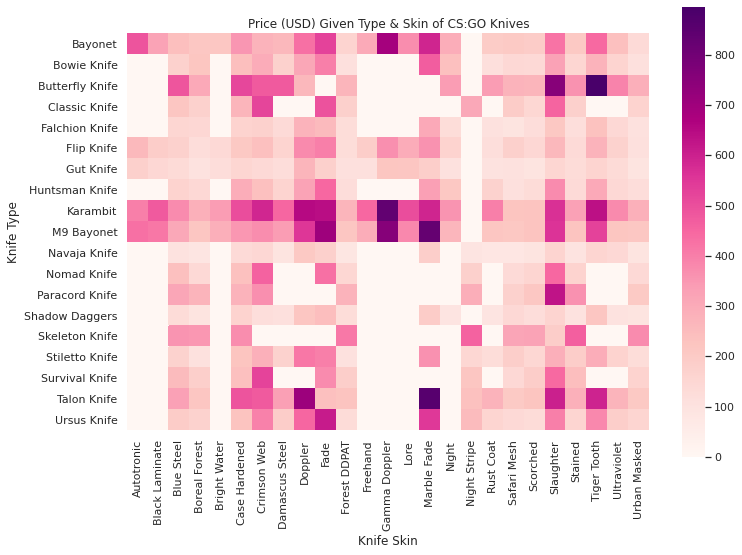

In [17]:
show_plot2()

##### Based on this data, Butterfly, Karambit, M9 Bayonet, Talon, and Ursus knives are the most expensive knife types across all knife skins (due to the darkest lines across the heatmap compared to the other knives). On the other hand, knives like the Gut Knife seem to be the cheapest across the knife skins (lightest horizontal line).

### Plot 3: Heatmap of Knives' Quantities Based on Knife Skin and Skin Quality

#### Prepare data/graph

##### Execute SQL query to obtain knife skin, knife skin quality, and quantity grouped by each skin. Because there are several variants of the Doppler skin in particular (variants that cannot be detected through the webscraper easily), this knife skin is skipped over as it makes the rest of the heatmap lighter and hard to tell trends. The Doppler skin is very common.

In [18]:
c.execute("SELECT knife_skin, knife_skin_quality, sum(quantity) "
          "FROM knives "
          "WHERE knife_skin_quality != 'N/A' AND knife_skin != 'Doppler' "
          "GROUP BY knife_skin, knife_skin_quality")

##### Convert cursor to useable data as a DataFrame object


In [0]:
data3 = c.fetchall()
df3 = pd.DataFrame(data3, columns=['Knife Skin',
                                 'Knife Skin Quality',
                                 'Quantity'])

##### Convert DataFrame object into pivot table to plot data as a heatmap

In [0]:
pivot3 = df3.pivot_table(values=['Quantity'],
                       index=['Knife Skin Quality'],
                       columns='Knife Skin',
                       fill_value=0) # White spaces on the heatmap are "null"

##### Generate manual x values (allows word formatting to be easier in graph)

In [21]:
x_values_3 = []

# Gets all unique Knife Skins while keeping format
[x_values_3.append(x) for x in df3['Knife Skin'] if x not in x_values_3]

x_values_3 = sorted(x_values_3)
print(x_values_3)

['Autotronic', 'Black Laminate', 'Blue Steel', 'Boreal Forest', 'Bright Water', 'Case Hardened', 'Crimson Web', 'Damascus Steel', 'Fade', 'Forest DDPAT', 'Freehand', 'Gamma Doppler', 'Lore', 'Marble Fade', 'Night', 'Night Stripe', 'Rust Coat', 'Safari Mesh', 'Scorched', 'Slaughter', 'Stained', 'Tiger Tooth', 'Ultraviolet', 'Urban Masked']


##### Set up heat map and plot data

In [0]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
def show_plot3():
  sns.heatmap(pivot3, cmap='RdPu', xticklabels=x_values_3, square=True)
  fig3 = plt
  fig3.title('Quantity Given Type & Skin of CS:GO Knives')
  fig3.xlabel('Knife Skin')
  fig3.ylabel('Knife Skin Quality')
  fig3.show()

#### Show graph

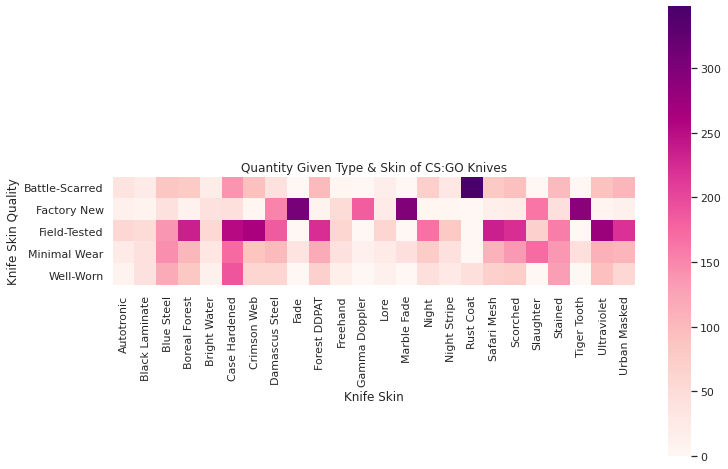

In [23]:
show_plot3()

##### Field-Tested is the most common skin quality on the Marketplace, and the Case Hardened skin is the most popular skin on the Marketplace across all qualities.

### Plot 4: Heatmap of Knives' Quantities Based on Knife Type and Skin

#### Prepare data/graph

##### Execute SQL query to obtain knife type, knife skin, and quantity grouped by each skin. Because there are several variants of the Doppler skin in particular (variants that cannot be detected through the webscraper easily), this knife skin is skipped over as it makes the rest of the heatmap lighter and hard to tell trends. The Doppler skin is very common.

In [24]:
c.execute("SELECT knife_type, knife_skin, sum(quantity) "
          "FROM knives "
          "WHERE knife_skin != 'N/A' AND knife_skin != 'Doppler' "
          "GROUP BY knife_type, knife_skin")

##### Convert cursor to useable data as a DataFrame object


In [0]:
data4 = c.fetchall()
df4 = pd.DataFrame(data4, columns=['Knife Type',
                                 'Knife Skin',
                                 'Quantity'])

##### Convert DataFrame object into pivot table to plot data as a heatmap

In [0]:
pivot4 = df4.pivot_table(values=['Quantity'],
                       index=['Knife Type'],
                       columns='Knife Skin',
                       fill_value=0) # White spaces on the heatmap are "null"

##### Generate manual x values (allows word formatting to be easier in graph)

In [27]:
x_values_4 = []

# Gets all unique Knife Skins while keeping format
[x_values_4.append(x) for x in df4['Knife Skin'] if x not in x_values_4]

x_values_4 = sorted(x_values_4)
print(x_values_4)

['Autotronic', 'Black Laminate', 'Blue Steel', 'Boreal Forest', 'Bright Water', 'Case Hardened', 'Crimson Web', 'Damascus Steel', 'Fade', 'Forest DDPAT', 'Freehand', 'Gamma Doppler', 'Lore', 'Marble Fade', 'Night', 'Night Stripe', 'Rust Coat', 'Safari Mesh', 'Scorched', 'Slaughter', 'Stained', 'Tiger Tooth', 'Ultraviolet', 'Urban Masked']


##### Set up heat map and plot data

In [0]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
def show_plot4():
  sns.heatmap(pivot4, cmap='RdPu', xticklabels=x_values_4, square=True)
  fig4 = plt
  fig4.title('Quantity Given Type & Skin of CS:GO Knives')
  fig4.xlabel('Knife Skin')
  fig4.ylabel('Knife Type')
  fig4.show()

#### Show graph

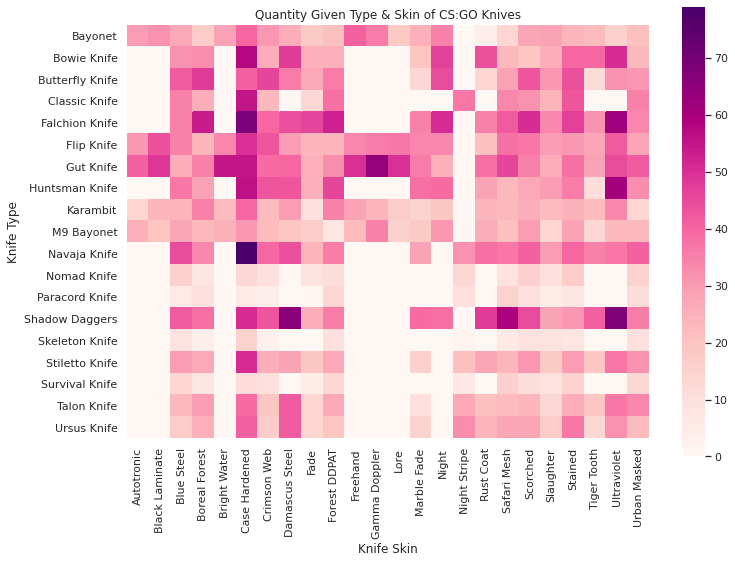

In [29]:
show_plot4()

##### Common knife types are the Falchion, Gut, Navaja, and the Shadow Daggers; the price of these knives compared to their supply makes intuitive sense (more of these types of knives => lower prices).